In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from preprocessing import complete_vars
from preprocessing import ratios
from preprocessing import breakdown_vars
from preprocessing import dummies_ohe
from preprocessing import Xy
from preprocessing import std_z
from preprocessing import standardize_X_test
from imblearn.under_sampling import RandomUnderSampler
from GeneticNeuralNetwork import gaMLP_ragnarok
from NeuralNetwork import MLPclassifer
from NeuralNetwork import MLP
from ineq import Theil
from LocalSearch import SA_max
from LocalSearch import search
from GeneticNeuralNetwork import gaMLP_score
from gentools import plot_stats
from gentools import select_optimun_parameters
from gentools import plot_stats

In [17]:
# Experiments .....
df_train = pd.read_csv("Datapooled.csv")

VARS = ['Ganancia bruta', 'Ganancia (pérdida)','Ingresos de actividades ordinarias' , 'Costo de ventas', 'Patrimonio total',
     'Total pasivos', 'Total de activos', 'Ganancias acumuladas',  'Pasivos corrientes totales',  'Activos corrientes totales']

df_train.rename(columns={'Clasificación Industrial Internacional Uniforme Versión 4 A.C':'Sector'}, inplace=True)

df_train = df_train[VARS+[ 'event', 'Sector']]
print(df_train[df_train['event']==1].info())
df_train['complete-vars'] = complete_vars(df_train) #1 is that have all variables!
df_train =  df_train[df_train['complete-vars']==1] #filtering firms that have not financial information 
print(df_train[df_train['event']==1].info())
df_train = ratios(df_train)
predictors =[ 'GPM', 'NPM', 'ROE','ROA', 'IR', 'DER', 'RSL', 'CR', 'Ax1', 'Ax2', 'Sector']
print(df_train[df_train['event']==1].info())
df_train.replace([np.inf,-np.inf], np.nan, inplace=True)
df_train.dropna(inplace=True)
df_train.drop(columns=['complete-vars'], inplace=True)
df_train = df_train[predictors + ['event']].copy()
df_exp = df_train.copy()
cat,binaries, nonormal, normal  = breakdown_vars(df_exp) 

X, y = Xy(df_train, 'event')
cat, binaries, nonormal, normal  = breakdown_vars(X)
nums = nonormal + normal
X = dummies_ohe(X, cat) 
print(y.value_counts())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True, random_state = 666, stratify=y)
print(y_train.value_counts())
rus = RandomUnderSampler(random_state=123)
X_train, y_train = rus.fit_resample(X_train, y_train)
X_test = standardize_X_test(X_train, X_test) # Apply the mean and std of X_test with info from X_train
X_train = std_z(nonormal + normal, X_train)

<class 'pandas.core.frame.DataFrame'>
Index: 771 entries, 4 to 26499
Data columns (total 12 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Ganancia bruta                      353 non-null    float64
 1   Ganancia (pérdida)                  353 non-null    float64
 2   Ingresos de actividades ordinarias  353 non-null    float64
 3   Costo de ventas                     330 non-null    float64
 4   Patrimonio total                    353 non-null    float64
 5   Total pasivos                       353 non-null    float64
 6   Total de activos                    353 non-null    float64
 7   Ganancias acumuladas                351 non-null    float64
 8   Pasivos corrientes totales          352 non-null    float64
 9   Activos corrientes totales          353 non-null    float64
 10  event                               771 non-null    float64
 11  Sector                              771 non-null

c:\Users\sjrp2\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [18]:
# Optimize f1..
# Directly optimization....
vars = [
'ROE', 'ROA', 
'IR', 'DER', 
'RSL', 'CR', 
'Sector_C', 'Sector_I',
'Sector_K', 'Sector_L', 
'Sector_O', 'Sector_Q',
'Sector_R', 'Sector_U'
]



# 32m 22.6 segundos para obtener las variables
X_train, X_test = X_train.loc[:, vars],  X_test.loc[:, vars]

architecture = (5,5,1) 
Pop_sizes  = [75]             # 75
generations = [150]           
Mutations = [0.07, 0.09]  #0.05, 0.09
Tournaments = [5] # 3,5 
Cross = [0.75, 0.85] # 0.75, 85
probs_mate = [0.5]  
probs_mutate = [0.04, 0.06]

regist = gaMLP_ragnarok(
    mutations = Mutations,
    architecture = architecture,
    pop_sizes = Pop_sizes,
    cross = Cross,
    max_generations= generations,
    tournament_sizes = Tournaments,
    mate_indpb = probs_mate,
    mutate_indpb = probs_mutate,
    classifier = MLPclassifer,
    ineq_measure = Theil,
    ineq_min = 0,
    k_folds=2,
    limit_unchanged = 100,
    X_train = X_train,
    y_train = y_train,
    verbose = True,
)

----------------------------------------
(75, 150, 5, 0.07, 0.75, 0.5, 0.04)
----------------------------------------


c:\Users\sjrp2\AppData\Local\Programs\Python\Python311\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\sjrp2\AppData\Local\Programs\Python\Python311\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


---------------
Generation:  1
---------------
Fitest : 0.6747967479674797 Inequality:  0.008734225880230536 Generation without improvement:  0
Stats mean:  0.6191170754878907 std:  0.13176211567517668 min: 0.0 max:  0.6747967479674797
0.6747967479674797 0.008734225880230536 0 (0.6191170754878907, 0.13176211567517668, 0.0, 0.6747967479674797)
---------------
Generation:  2
---------------
Fitest : 0.6747967479674797 Inequality:  0.006904773401902241 Generation without improvement:  1
Stats mean:  0.6367085010844025 std:  0.11796795047495678 min: 0.0 max:  0.6747967479674797
0.6747967479674797 0.006904773401902241 1 (0.6367085010844025, 0.11796795047495678, 0.0, 0.6747967479674797)


c:\Users\sjrp2\Desktop\napo\IA-trujillo\Thesis-puj\Final Notebooks\NeuralNetwork.py:74: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


---------------
Generation:  3
---------------
Fitest : 0.67581317764804 Inequality:  0.007208001227598027 Generation without improvement:  2
Stats mean:  0.6189254513961897 std:  0.12360292880698623 min: 0.015625 max:  0.67581317764804
0.67581317764804 0.007208001227598027 2 (0.6189254513961897, 0.12360292880698623, 0.015625, 0.67581317764804)
---------------
Generation:  4
---------------
Fitest : 0.7036247698288209 Inequality:  0.009331736637901364 Generation without improvement:  3
Stats mean:  0.621997008477805 std:  0.14415264228864363 min: 0.030828861061419202 max:  0.7036247698288209
0.7036247698288209 0.009331736637901364 3 (0.621997008477805, 0.14415264228864363, 0.030828861061419202, 0.7036247698288209)
---------------
Generation:  5
---------------
Fitest : 0.705495346168558 Inequality:  0.008732172308629221 Generation without improvement:  0
Stats mean:  0.6325210838125791 std:  0.13660952167648197 min: 0.0 max:  0.705495346168558
0.705495346168558 0.008732172308629221 0 (

c:\Users\sjrp2\AppData\Local\Programs\Python\Python311\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\sjrp2\AppData\Local\Programs\Python\Python311\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


---------------
Generation:  1
---------------
Fitest : 0.6747967479674797 Inequality:  0.008743906700835432 Generation without improvement:  0
Stats mean:  0.6190431139883973 std:  0.13185525000277076 min: 0.0 max:  0.6747967479674797
0.6747967479674797 0.008743906700835432 0 (0.6190431139883973, 0.13185525000277076, 0.0, 0.6747967479674797)


c:\Users\sjrp2\Desktop\napo\IA-trujillo\Thesis-puj\Final Notebooks\NeuralNetwork.py:74: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


---------------
Generation:  2
---------------
Fitest : 0.6747967479674797 Inequality:  0.007320076655118367 Generation without improvement:  1
Stats mean:  0.6184117460426586 std:  0.12533471612157285 min: 0.0 max:  0.6747967479674797
0.6747967479674797 0.007320076655118367 1 (0.6184117460426586, 0.12533471612157285, 0.0, 0.6747967479674797)
---------------
Generation:  3
---------------
Fitest : 0.6852910170337901 Inequality:  0.013248975587998854 Generation without improvement:  2
Stats mean:  0.6041178922497112 std:  0.15605632741213463 min: 0.0 max:  0.6852910170337901
0.6852910170337901 0.013248975587998854 2 (0.6041178922497112, 0.15605632741213463, 0.0, 0.6852910170337901)
---------------
Generation:  4
---------------
Fitest : 0.6796014158202524 Inequality:  0.007120411916257634 Generation without improvement:  0
Stats mean:  0.6319410149253716 std:  0.11713045252678757 min: 0.0 max:  0.6796014158202524
0.6796014158202524 0.007120411916257634 0 (0.6319410149253716, 0.117130452

c:\Users\sjrp2\AppData\Local\Programs\Python\Python311\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\sjrp2\AppData\Local\Programs\Python\Python311\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


---------------
Generation:  1
---------------
Fitest : 0.6737869492470719 Inequality:  0.012539245687468392 Generation without improvement:  0
Stats mean:  0.5935745598023207 std:  0.1591285820270107 min: 0.0078125 max:  0.6737869492470719
0.6737869492470719 0.012539245687468392 0 (0.5935745598023207, 0.1591285820270107, 0.0078125, 0.6737869492470719)
---------------
Generation:  2
---------------
Fitest : 0.6919642857142857 Inequality:  0.014672195105748301 Generation without improvement:  1
Stats mean:  0.6023905869133434 std:  0.16872106333029172 min: 0.0 max:  0.6919642857142857
0.6919642857142857 0.014672195105748301 1 (0.6023905869133434, 0.16872106333029172, 0.0, 0.6919642857142857)
---------------
Generation:  3
---------------
Fitest : 0.6919642857142857 Inequality:  0.009827226852819268 Generation without improvement:  0
Stats mean:  0.6225354218137432 std:  0.13975013131360722 min: 0.0 max:  0.6919642857142857
0.6919642857142857 0.009827226852819268 0 (0.6225354218137432, 0

c:\Users\sjrp2\Desktop\napo\IA-trujillo\Thesis-puj\Final Notebooks\NeuralNetwork.py:74: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


---------------
Generation:  4
---------------
Fitest : 0.6847680343255564 Inequality:  0.003817216721577412 Generation without improvement:  1
Stats mean:  0.6342159447210501 std:  0.09755765330062349 min: 0.056556582104027364 max:  0.6847680343255564
0.6847680343255564 0.003817216721577412 1 (0.6342159447210501, 0.09755765330062349, 0.056556582104027364, 0.6847680343255564)
---------------
Generation:  5
---------------
Fitest : 0.7203248205248911 Inequality:  0.0018661042029132525 Generation without improvement:  0
Stats mean:  0.6535739399020088 std:  0.07333982910822683 min: 0.21286764705882352 max:  0.7203248205248911
0.7203248205248911 0.0018661042029132525 0 (0.6535739399020088, 0.07333982910822683, 0.21286764705882352, 0.7203248205248911)
---------------
Generation:  6
---------------
Fitest : 0.7024278896036522 Inequality:  0.006931370333695608 Generation without improvement:  0
Stats mean:  0.6300205785085953 std:  0.12324272170249002 min: 0.0 max:  0.7024278896036522
0.7024

c:\Users\sjrp2\AppData\Local\Programs\Python\Python311\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\sjrp2\AppData\Local\Programs\Python\Python311\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


---------------
Generation:  1
---------------
Fitest : 0.6737869492470719 Inequality:  0.012555832014397878 Generation without improvement:  0
Stats mean:  0.5931458162172284 std:  0.15919860605279718 min: 0.0078125 max:  0.6737869492470719
0.6737869492470719 0.012555832014397878 0 (0.5931458162172284, 0.15919860605279718, 0.0078125, 0.6737869492470719)
---------------
Generation:  2
---------------
Fitest : 0.6730518751403548 Inequality:  0.01076695500524535 Generation without improvement:  1
Stats mean:  0.6177033383760793 std:  0.14357454801787226 min: 0.0 max:  0.6730518751403548
0.6730518751403548 0.01076695500524535 1 (0.6177033383760793, 0.14357454801787226, 0.0, 0.6730518751403548)
---------------
Generation:  3
---------------
Fitest : 0.6693028746007499 Inequality:  0.0007888223093468149 Generation without improvement:  2
Stats mean:  0.6527377241988295 std:  0.05003878688637326 min: 0.3242150848069289 max:  0.6693028746007499
0.6693028746007499 0.0007888223093468149 2 (0.65

c:\Users\sjrp2\Desktop\napo\IA-trujillo\Thesis-puj\Final Notebooks\NeuralNetwork.py:74: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


---------------
Generation:  7
---------------
Fitest : 0.6728983957219252 Inequality:  0.0008395334775089389 Generation without improvement:  6
Stats mean:  0.6592253898342565 std:  0.04910964059581935 min: 0.2440439504388668 max:  0.6728983957219252
0.6728983957219252 0.0008395334775089389 6 (0.6592253898342565, 0.04910964059581935, 0.2440439504388668, 0.6728983957219252)
---------------
Generation:  8
---------------
Fitest : 0.6728983957219252 Inequality:  0.0005087816146014631 Generation without improvement:  7
Stats mean:  0.6603152730156027 std:  0.04001425011363911 min: 0.33843617522374 max:  0.6728983957219252
0.6728983957219252 0.0005087816146014631 7 (0.6603152730156027, 0.04001425011363911, 0.33843617522374, 0.6728983957219252)


c:\Users\sjrp2\Desktop\napo\IA-trujillo\Thesis-puj\Final Notebooks\NeuralNetwork.py:74: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
c:\Users\sjrp2\Desktop\napo\IA-trujillo\Thesis-puj\Final Notebooks\NeuralNetwork.py:74: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


---------------
Generation:  9
---------------
Fitest : 0.6737659574468085 Inequality:  0.0005937223391675688 Generation without improvement:  8
Stats mean:  0.65840219239973 std:  0.0439887293774996 min: 0.37084394422381706 max:  0.6737659574468085
0.6737659574468085 0.0005937223391675688 8 (0.65840219239973, 0.0439887293774996, 0.37084394422381706, 0.6737659574468085)
---------------
Generation:  10
---------------
Fitest : 0.6756954184198223 Inequality:  0.0009951651243195634 Generation without improvement:  9
Stats mean:  0.6535663497642371 std:  0.05553528753757138 min: 0.2886376093708764 max:  0.6756954184198223
0.6756954184198223 0.0009951651243195634 9 (0.6535663497642371, 0.05553528753757138, 0.2886376093708764, 0.6756954184198223)
---------------
Generation:  11
---------------
Fitest : 0.6846540941958179 Inequality:  0.0020196244988135233 Generation without improvement:  10
Stats mean:  0.6573920967202771 std:  0.06929898287050447 min: 0.08028122956180511 max:  0.68465409419

c:\Users\sjrp2\Desktop\napo\IA-trujillo\Thesis-puj\Final Notebooks\NeuralNetwork.py:74: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


---------------
Generation:  18
---------------
Fitest : 0.6999399553954366 Inequality:  3.339800541094598e-05 Generation without improvement:  6
Stats mean:  0.6940119902530415 std:  0.011535226890582971 min: 0.5994118360417172 max:  0.6999399553954366
0.6999399553954366 3.339800541094598e-05 6 (0.6940119902530415, 0.011535226890582971, 0.5994118360417172, 0.6999399553954366)
---------------
Generation:  19
---------------
Fitest : 0.6999399553954366 Inequality:  2.1452842553679534e-06 Generation without improvement:  7
Stats mean:  0.696499078856952 std:  0.0029942804538928888 min: 0.684495078104215 max:  0.6999399553954366
0.6999399553954366 2.1452842553679534e-06 7 (0.696499078856952, 0.0029942804538928888, 0.684495078104215, 0.6999399553954366)
---------------
Generation:  20
---------------
Fitest : 0.7032003393381174 Inequality:  4.251477630907068e-05 Generation without improvement:  8
Stats mean:  0.6954807213606735 std:  0.013039751451168728 min: 0.5935935935935936 max:  0.703

c:\Users\sjrp2\Desktop\napo\IA-trujillo\Thesis-puj\Final Notebooks\NeuralNetwork.py:74: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


---------------
Generation:  81
---------------
Fitest : 0.7277705845681677 Inequality:  1.4189070828437119e-05 Generation without improvement:  69
Stats mean:  0.7262113570119882 std:  0.007945531550872669 min: 0.6666666666666666 max:  0.7277705845681677
0.7277705845681677 1.4189070828437119e-05 69 (0.7262113570119882, 0.007945531550872669, 0.6666666666666666, 0.7277705845681677)
---------------
Generation:  82
---------------
Fitest : 0.7277705845681677 Inequality:  3.777000278739462e-06 Generation without improvement:  70
Stats mean:  0.7268702422562273 std:  0.004130964460602922 min: 0.7017756255044391 max:  0.7277705845681677
0.7277705845681677 3.777000278739462e-06 70 (0.7268702422562273, 0.004130964460602922, 0.7017756255044391, 0.7277705845681677)
---------------
Generation:  83
---------------
Fitest : 0.7277705845681677 Inequality:  3.597037818588316e-05 Generation without improvement:  71
Stats mean:  0.7259936816613966 std:  0.012478472192461358 min: 0.6194793799356537 max:

c:\Users\sjrp2\Desktop\napo\IA-trujillo\Thesis-puj\Final Notebooks\NeuralNetwork.py:74: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


---------------
Generation:  103
---------------
Fitest : 0.7288600288600289 Inequality:  4.520562825907528e-06 Generation without improvement:  91
Stats mean:  0.727647512431038 std:  0.0045253255116542304 min: 0.7017966242104172 max:  0.7288600288600289
0.7288600288600289 4.520562825907528e-06 91 (0.727647512431038, 0.0045253255116542304, 0.7017966242104172, 0.7288600288600289)
---------------
Generation:  104
---------------
Fitest : 0.7288600288600289 Inequality:  2.677479215959671e-06 Generation without improvement:  92
Stats mean:  0.7282280507396091 std:  0.003483134686297767 min: 0.7017079676475649 max:  0.7288600288600289
0.7288600288600289 2.677479215959671e-06 92 (0.7282280507396091, 0.003483134686297767, 0.7017079676475649, 0.7288600288600289)
---------------
Generation:  105
---------------
Fitest : 0.7288600288600289 Inequality:  5.5493301714636455e-05 Generation without improvement:  93
Stats mean:  0.7263586975174056 std:  0.015436487791567642 min: 0.5974032501256492 ma

c:\Users\sjrp2\AppData\Local\Programs\Python\Python311\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\sjrp2\AppData\Local\Programs\Python\Python311\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


---------------
Generation:  1
---------------
Fitest : 0.6737869492470719 Inequality:  0.01085754311976384 Generation without improvement:  0
Stats mean:  0.6110472652788262 std:  0.14603132238505845 min: 0.0 max:  0.6737869492470719
0.6737869492470719 0.01085754311976384 0 (0.6110472652788262, 0.14603132238505845, 0.0, 0.6737869492470719)
---------------
Generation:  2
---------------
Fitest : 0.6764682752457551 Inequality:  0.010525112070678 Generation without improvement:  1
Stats mean:  0.6134388722164421 std:  0.1449039735700956 min: 0.0 max:  0.6764682752457551
0.6764682752457551 0.010525112070678 1 (0.6134388722164421, 0.1449039735700956, 0.0, 0.6764682752457551)
---------------
Generation:  3
---------------
Fitest : 0.6764682752457551 Inequality:  0.008355642237577834 Generation without improvement:  2
Stats mean:  0.6362882263841927 std:  0.12678135081224196 min: 0.0 max:  0.6764682752457551
0.6764682752457551 0.008355642237577834 2 (0.6362882263841927, 0.12678135081224196, 

c:\Users\sjrp2\Desktop\napo\IA-trujillo\Thesis-puj\Final Notebooks\NeuralNetwork.py:74: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


---------------
Generation:  4
---------------
Fitest : 0.6826282839979736 Inequality:  0.010287784348775354 Generation without improvement:  3
Stats mean:  0.6110815410964591 std:  0.14669016877688332 min: 0.0 max:  0.6826282839979736
0.6826282839979736 0.010287784348775354 3 (0.6110815410964591, 0.14669016877688332, 0.0, 0.6826282839979736)
---------------
Generation:  5
---------------
Fitest : 0.6936632392757094 Inequality:  0.001651706599717308 Generation without improvement:  4
Stats mean:  0.6452585261549189 std:  0.07201552134396341 min: 0.27888007054673725 max:  0.6936632392757094
0.6936632392757094 0.001651706599717308 4 (0.6452585261549189, 0.07201552134396341, 0.27888007054673725, 0.6936632392757094)
---------------
Generation:  6
---------------
Fitest : 0.7062672811059908 Inequality:  0.0021272895763792894 Generation without improvement:  0
Stats mean:  0.650774261914111 std:  0.07955816469054247 min: 0.1907892067356462 max:  0.7062672811059908
0.7062672811059908 0.002127

c:\Users\sjrp2\AppData\Local\Programs\Python\Python311\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\sjrp2\AppData\Local\Programs\Python\Python311\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


---------------
Generation:  1
---------------
Fitest : 0.6737869492470719 Inequality:  0.008814733230800887 Generation without improvement:  0
Stats mean:  0.6171971131577252 std:  0.13234952567465316 min: 0.0 max:  0.6737869492470719
0.6737869492470719 0.008814733230800887 0 (0.6171971131577252, 0.13234952567465316, 0.0, 0.6737869492470719)
---------------
Generation:  2
---------------
Fitest : 0.6806334029380519 Inequality:  0.009607216513342861 Generation without improvement:  1
Stats mean:  0.6248460500196881 std:  0.13938322048140298 min: 0.0 max:  0.6806334029380519
0.6806334029380519 0.009607216513342861 1 (0.6248460500196881, 0.13938322048140298, 0.0, 0.6806334029380519)


c:\Users\sjrp2\Desktop\napo\IA-trujillo\Thesis-puj\Final Notebooks\NeuralNetwork.py:74: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
c:\Users\sjrp2\Desktop\napo\IA-trujillo\Thesis-puj\Final Notebooks\NeuralNetwork.py:74: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


---------------
Generation:  3
---------------
Fitest : 0.6806334029380519 Inequality:  0.004050606108995306 Generation without improvement:  0
Stats mean:  0.6228637831239945 std:  0.10505240311132225 min: 0.2049476439790576 max:  0.6806334029380519
0.6806334029380519 0.004050606108995306 0 (0.6228637831239945, 0.10505240311132225, 0.2049476439790576, 0.6806334029380519)
---------------
Generation:  4
---------------
Fitest : 0.693528131680615 Inequality:  0.011272895285748544 Generation without improvement:  1
Stats mean:  0.6097660850390997 std:  0.14711475193949697 min: 0.0 max:  0.693528131680615
0.693528131680615 0.011272895285748544 1 (0.6097660850390997, 0.14711475193949697, 0.0, 0.693528131680615)


c:\Users\sjrp2\Desktop\napo\IA-trujillo\Thesis-puj\Final Notebooks\NeuralNetwork.py:74: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


---------------
Generation:  5
---------------
Fitest : 0.6967707537560479 Inequality:  0.004139690328145204 Generation without improvement:  0
Stats mean:  0.6383408174143637 std:  0.1024890215870701 min: 0.05031282586027111 max:  0.6967707537560479
0.6967707537560479 0.004139690328145204 0 (0.6383408174143637, 0.1024890215870701, 0.05031282586027111, 0.6967707537560479)


c:\Users\sjrp2\Desktop\napo\IA-trujillo\Thesis-puj\Final Notebooks\NeuralNetwork.py:74: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


---------------
Generation:  6
---------------
Fitest : 0.6967707537560479 Inequality:  0.0011595405376982433 Generation without improvement:  1
Stats mean:  0.6551196649416369 std:  0.061501547188615766 min: 0.35009914077990745 max:  0.6967707537560479
0.6967707537560479 0.0011595405376982433 1 (0.6551196649416369, 0.061501547188615766, 0.35009914077990745, 0.6967707537560479)
---------------
Generation:  7
---------------
Fitest : 0.7042285200179936 Inequality:  0.0009973969230521265 Generation without improvement:  2
Stats mean:  0.6728933182615997 std:  0.05427415835048728 min: 0.22321702874698265 max:  0.7042285200179936
0.7042285200179936 0.0009973969230521265 2 (0.6728933182615997, 0.05427415835048728, 0.22321702874698265, 0.7042285200179936)
---------------
Generation:  8
---------------
Fitest : 0.703729459395094 Inequality:  0.003363664535463389 Generation without improvement:  0
Stats mean:  0.6715641748561094 std:  0.08364796545445685 min: 0.0 max:  0.703729459395094
0.7037

c:\Users\sjrp2\AppData\Local\Programs\Python\Python311\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\sjrp2\AppData\Local\Programs\Python\Python311\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


---------------
Generation:  1
---------------
Fitest : 0.6737869492470719 Inequality:  0.012548666880216629 Generation without improvement:  0
Stats mean:  0.5930102785274621 std:  0.15910326496935515 min: 0.0078125 max:  0.6737869492470719
0.6737869492470719 0.012548666880216629 0 (0.5930102785274621, 0.15910326496935515, 0.0078125, 0.6737869492470719)
---------------
Generation:  2
---------------
Fitest : 0.6737869492470719 Inequality:  0.008559575423565618 Generation without improvement:  1
Stats mean:  0.6258747818105993 std:  0.1319392760870671 min: 0.0 max:  0.6737869492470719
0.6737869492470719 0.008559575423565618 1 (0.6258747818105993, 0.1319392760870671, 0.0, 0.6737869492470719)
---------------
Generation:  3
---------------
Fitest : 0.6737869492470719 Inequality:  0.0007526985138861014 Generation without improvement:  2
Stats mean:  0.6524709881263082 std:  0.04940139977874711 min: 0.3545182972367439 max:  0.6737869492470719
0.6737869492470719 0.0007526985138861014 2 (0.65

c:\Users\sjrp2\AppData\Local\Programs\Python\Python311\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\sjrp2\AppData\Local\Programs\Python\Python311\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


---------------
Generation:  1
---------------
Fitest : 0.6737869492470719 Inequality:  0.012602600409778066 Generation without improvement:  0
Stats mean:  0.5923905502392012 std:  0.15944014452276656 min: 0.0078125 max:  0.6737869492470719
0.6737869492470719 0.012602600409778066 0 (0.5923905502392012, 0.15944014452276656, 0.0078125, 0.6737869492470719)
---------------
Generation:  2
---------------
Fitest : 0.6737869492470719 Inequality:  0.007921581524796327 Generation without improvement:  1
Stats mean:  0.6307325495442472 std:  0.12644525038077906 min: 0.0 max:  0.6737869492470719
0.6737869492470719 0.007921581524796327 1 (0.6307325495442472, 0.12644525038077906, 0.0, 0.6737869492470719)
---------------
Generation:  3
---------------
Fitest : 0.6737869492470719 Inequality:  0.010167589755312394 Generation without improvement:  2
Stats mean:  0.6163405067972191 std:  0.14546658933175258 min: 0.0 max:  0.6737869492470719
0.6737869492470719 0.010167589755312394 2 (0.6163405067972191,

In [19]:
parameters_ = select_optimun_parameters(regist=regist,
                           architecture=architecture,
                             k_folds=10, 
                             X_train=X_train, 
                             y_train=y_train,
                             assessment_metric = recall_score)

From here is the fittest (75, 150, 5, 0.07, 0.75, 0.5, 0.04)
(0.9615384615384616, 0.0018000000000000238)


In [20]:
fittest_individual, history, stats = gaMLP_score(
                    classifier = MLPclassifer,
                    architecture= architecture,
                    population_size=parameters_[0],
                    max_generations= parameters_[1],
                    tournament_size=parameters_[2],
                    MUTPB=parameters_[3],
                    CXPB=parameters_[4], 
                    mate_indpb= parameters_[5],
                    mutate_indpb=parameters_[6],
                    ineq_measure=Theil,
                    ineq_min  = 0,
                    limit_unchanged=100,
                    k_folds=2,
                    X_train = X_train, 
                    y_train = y_train,
                    verbose=True)

c:\Users\sjrp2\AppData\Local\Programs\Python\Python311\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\sjrp2\AppData\Local\Programs\Python\Python311\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


---------------
Generation:  1
---------------
Fitest : 0.6747967479674797 Inequality:  0.008734225880230536 Generation without improvement:  0
Stats mean:  0.6191170754878907 std:  0.13176211567517668 min: 0.0 max:  0.6747967479674797
0.6747967479674797 0.008734225880230536 0 (0.6191170754878907, 0.13176211567517668, 0.0, 0.6747967479674797)
---------------
Generation:  2
---------------
Fitest : 0.6747967479674797 Inequality:  0.006904773401902241 Generation without improvement:  1
Stats mean:  0.6367085010844025 std:  0.11796795047495678 min: 0.0 max:  0.6747967479674797
0.6747967479674797 0.006904773401902241 1 (0.6367085010844025, 0.11796795047495678, 0.0, 0.6747967479674797)


c:\Users\sjrp2\Desktop\napo\IA-trujillo\Thesis-puj\Final Notebooks\NeuralNetwork.py:74: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


---------------
Generation:  3
---------------
Fitest : 0.67581317764804 Inequality:  0.007208001227598027 Generation without improvement:  2
Stats mean:  0.6189254513961897 std:  0.12360292880698623 min: 0.015625 max:  0.67581317764804
0.67581317764804 0.007208001227598027 2 (0.6189254513961897, 0.12360292880698623, 0.015625, 0.67581317764804)
---------------
Generation:  4
---------------
Fitest : 0.7036247698288209 Inequality:  0.009331736637901364 Generation without improvement:  3
Stats mean:  0.621997008477805 std:  0.14415264228864363 min: 0.030828861061419202 max:  0.7036247698288209
0.7036247698288209 0.009331736637901364 3 (0.621997008477805, 0.14415264228864363, 0.030828861061419202, 0.7036247698288209)
---------------
Generation:  5
---------------
Fitest : 0.705495346168558 Inequality:  0.008732172308629221 Generation without improvement:  0
Stats mean:  0.6325210838125791 std:  0.13660952167648197 min: 0.0 max:  0.705495346168558
0.705495346168558 0.008732172308629221 0 (

In [21]:
MLP(architecture=architecture, X_train=X_test, y_train=y_test, initial_solution=fittest_individual, score=f1_score)

c:\Users\sjrp2\Desktop\napo\IA-trujillo\Thesis-puj\Final Notebooks\NeuralNetwork.py:74: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


(0.04943273905996758,)

In [22]:
preds_GA = np.where(MLP(architecture=architecture, X_train=X_test, y_train=y_test, initial_solution=fittest_individual, preds=True)>0.5,1,0)
GA  = pd.DataFrame(classification_report(y_test, preds_GA, output_dict=True)).iloc[:,0:2]


c:\Users\sjrp2\Desktop\napo\IA-trujillo\Thesis-puj\Final Notebooks\NeuralNetwork.py:74: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


In [23]:
GA

,0.0,1.0
precision,0.996862,0.025374
recall,0.289138,0.953125
f1-score,0.448260,0.049433
support,3296.000000,64.000000


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


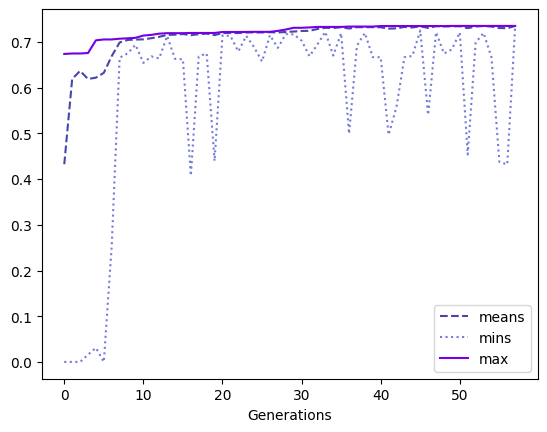

In [24]:
plot_stats(stats, "convergenceOptimun.eps")

In [25]:
fittest_individual

[8.684450077412246,
 -9.473421745690288,
 -9.555074411252313,
 -5.55143276195613,
 -6.277267427014083,
 -13.188227461006555,
 13.142324158700902,
 2.1358119990854005,
 0.5105068778645152,
 8.517895740947608,
 14.306738584034582,
 -5.618867353459747,
 20.47418125905665,
 -16.463179150279508,
 -0.4084953664813556,
 -3.084098040161265,
 -5.098298692756839,
 -16.231580142631415,
 20.47385834561913,
 13.157404961017464,
 -7.9291654309426205,
 -7.2996067404961735,
 -1.7261515529054114,
 -9.968700362834745,
 1.5282928694831828,
 -2.56271399525997,
 0.08718120697482012,
 1.6198626718199614,
 3.481843081032703,
 -1.0765354372969982,
 -1.8457078497032262,
 0.9126843892693919,
 11.425361298158219,
 9.470862319839545,
 6.248749879193225,
 -6.466684998046006,
 7.483623505568775,
 -0.9925246878512117,
 5.896705152978392,
 -7.953878556749593,
 1.2459988690404191,
 -11.039375039356479,
 -1.135849254256145,
 -4.53685270956304,
 14.344043047572042,
 -16.825012906422433,
 3.759461544840116,
 -23.05293687

In [26]:
MLP(architecture=architecture,
                                       X_train = X_train,
                                       y_train = y_train,
                                       initial_solution=fittest_individual, score=f1_score)

(0.7351190476190477,)

In [27]:
SAsolution  = SA_max(
    solution = fittest_individual,
    search = search,
    Tf= 0,
    cooling_rate = 35,  
    beta = 0.001,
    reduce_temp=0.000001,  #0.0001
    seed_random= 777,
    alpha = 0.1, #0.1
    max_iterations = 180, #180
    fitnessFunction = lambda x: MLP(architecture=architecture,
                                       X_train = X_train,
                                       y_train = y_train,
                                       initial_solution=x,
                                       score = f1_score))

1
(0.736998514115899,) Temperarure : 0.0007341190476190477
2
(0.7348148148148148,) Temperarure : 0.0007331190476190477
3
(0.7340267459138187,) Temperarure : 0.0007321190476190476
4
(0.7337278106508875,) Temperarure : 0.0007311190476190476
5
(0.7318518518518519,) Temperarure : 0.0007301190476190476
6
(0.7337278106508875,) Temperarure : 0.0007291190476190476
7
(0.7337278106508875,) Temperarure : 0.0007281190476190475
8
(0.736214605067064,) Temperarure : 0.0007271190476190475
9
(0.7351190476190477,) Temperarure : 0.0007261190476190475
10
(0.7340267459138187,) Temperarure : 0.0007251190476190475
11
(0.7351190476190477,) Temperarure : 0.0007241190476190474
12
(0.736998514115899,) Temperarure : 0.0007231190476190474
13
(0.7340267459138187,) Temperarure : 0.0007221190476190474
14
(0.7340267459138187,) Temperarure : 0.0007211190476190474
15
(0.7359050445103857,) Temperarure : 0.0007201190476190473
16
(0.7359050445103857,) Temperarure : 0.0007191190476190473
17
(0.7359050445103857,) Temperarure

In [28]:
MLP(architecture=architecture, X_train=X_train, y_train=y_train, 
                          initial_solution=SAsolution['major'][1],  score=f1_score)

(0.75,)

In [29]:
preds_GASA = np.where(MLP(architecture=architecture, X_train=X_test, y_train=y_test, 
                          initial_solution=SAsolution['major'][1], 
                          preds=True)>0.5,1,0)
GASA  = pd.DataFrame(classification_report(y_test, preds_GASA, output_dict=True)).iloc[:,0:2]


c:\Users\sjrp2\Desktop\napo\IA-trujillo\Thesis-puj\Final Notebooks\NeuralNetwork.py:74: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


In [30]:
models_tab = pd.concat([GA, GASA], axis=1)
cols_names =  pd.MultiIndex.from_tuples([('Genetic training f1','No-Default'),("Genetic training f1",'Deafult'),
              ("Genetic annealing training f1",'No-Default'),('Genetic annealing training f1','Default')])
models_tab.columns  = cols_names
models_tab = models_tab.style.set_table_styles([
   {'selector': 'th','props': [('text-align', 'center')]}]).format(precision=2)
models_tab.to_latex("f1-models.tex")
models_tab